### *This file allows to initialize a STG spiking neuron as well as neuromodulating them in a robust way with a controller*

# **Useful packages and functions**

In [1]:
using Plots, LaTeXStrings, Random, Dierckx, DelimitedFiles
include("quad_STG_kinetics.jl") # Loading of STG kinetics of gating variables
include("quad_STG_models.jl") # Loading of STG model
include("quad_STG_utils.jl") # Loading of some utils functions
include("quad_STG_gs_derivatives.jl") # Loading of X_inf derivatives
include("quad_STG_DIC.jl") # Loading of the DIC and compensation algorithm
include("quad_STG_neuromodulation.jl"); # Loading of the neuromodulation cells functions

┌ Info: Precompiling Dierckx [39dd38d3-220a-591b-8e3c-4c3a8c710a94]
└ @ Base loading.jl:1664


# **Global variables**

In [7]:
# Definition of simulation time (in ms)
const Tfinal = 50000
const dt = 0.0005
const tsim = 0 : dt : Tfinal
const dtplot = 0.2
const tt = 0 : dtplot : Tfinal
const dtratio = Int(dtplot/dt)
const Tdt = Int(Tfinal/dt)
const tt_index = 1 : dtratio : Tdt+1

# Definition of reversal potential values (in mV) and membrane capacitance
const VNa   = 50. # Sodium reversal potential
const VK    = -80. # Potassium reversal potential
const VCa   = 80. # Calcium reversal potential
const VH    = -20. # Reversal potential for the H-current (permeable to both sodium and potassium ions)
const Vleak = -50. # Reversal potential of leak channels
const Vsyn = -75. # Reversal potential of synaptic channels
const C     = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 40
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 1

# Modifying backend GR attributes
gr(guidefontsize=18, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
blueTrot = RGBA(184/255, 199/255, 209/255, 1)
redGallop = RGBA(255/255, 99/255, 99/255, 1)
default(fmt = :png);

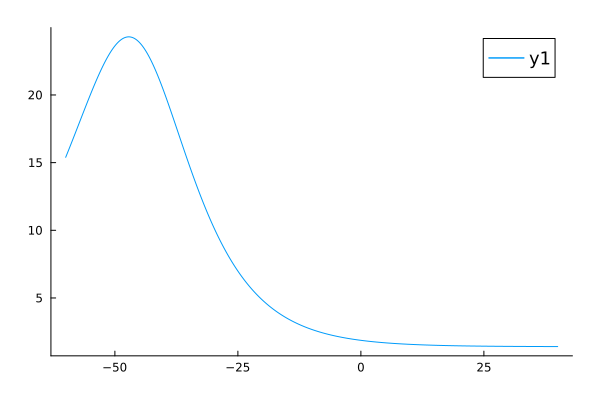

In [3]:
plot(V, tau_mCaS.(V))

# **Test of simple modulated network with non constant DICs**

In [4]:
# Fixing random seed
Random.seed!(544)

# Initial firing pattern
guth = 4.
Vth = -50.
tmKCavec = 4*ones(8)
(g_all_init, ICs_th_init) = degeneracy_fixDICs_neuromod(ncells, 5., guth, Vth, tmKCavec);
# create a spiking set with max variability in gCaS and gA

In [5]:
# Definition of parameters
Iappvec = 0. * ones(8)
gNavec = g_all_init[1] * ones(8)
gCaTvec = g_all_init[2] * ones(8)
gCaSvec = g_all_init[3] * ones(8)
gAvec = g_all_init[4] * ones(8)
gKCavec = g_all_init[5] * ones(8)
gKdvec = g_all_init[6] * ones(8)
gHvec = g_all_init[7] * ones(8)
gleakvec = g_all_init[8] * ones(8)

α = 5e-3 # Rate of transfer between intracellular and membrane
β = 5e-3 # Rate of degradation of intracellular proteins
Kp = 3e-4 # Proprtional gain
Ki = 5e-6 # Integral gain
Kt = β / Ki # Anti-windup gain
gsth_sim_burst(t) = -8.
gsth_sim_spike(t) = 5.
gsth_spike2burst(t) = 5. - 13. * (t>Tfinal/2)
gsth_burst2spike(t) = -8. + 13. * (t>Tfinal/2)
gsthvec_trot2gallop = [gsth_sim_burst, gsth_sim_burst, gsth_sim_burst, gsth_sim_burst, 
                       gsth_spike2burst, gsth_spike2burst, gsth_burst2spike, gsth_burst2spike]
gsthvec_gallop2trot = [gsth_sim_burst, gsth_sim_burst, gsth_sim_burst, gsth_sim_burst, 
                       gsth_burst2spike, gsth_burst2spike, gsth_spike2burst, gsth_spike2burst]
guth_sim(t) = 4.
guthvec = [guth_sim, guth_sim, guth_sim, guth_sim, guth_sim, guth_sim, guth_sim, guth_sim]
u_maxCaS = 1e7 # Maximum value of actuator
u_maxA = 1e7
Vthvec = ICs_th_init[1] * ones(8)

gsyn_HC = 0.8
gsyn_drive = 0.8
gsyn = [gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; 
        gsyn_drive; gsyn_drive; gsyn_drive; gsyn_drive; gsyn_drive; gsyn_drive; gsyn_drive; gsyn_drive]
gsyngallop = [gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; 
              gsyn_drive; gsyn_drive; gsyn_drive; gsyn_drive; 0; 0; 0; 0]
gsyntrot = [gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; gsyn_HC; 
              0; 0; 0; 0; gsyn_drive; gsyn_drive; gsyn_drive; gsyn_drive]

# @time Vtrot2gallop = simulateSTG_network(Iappvec, gNavec, gCaTvec, gCaSvec, gAvec, gKCavec, gKdvec, 
#                                          gHvec, gleakvec, gsyn, tmKCavec, α, β, Kp, Ki, Kt, 
#                                          gsthvec_trot2gallop, guthvec, Vthvec, u_maxCaS, u_maxA)

@time Vgallop2trot = simulateSTG_network(Iappvec, gNavec, gCaTvec, gCaSvec, gAvec, gKCavec, gKdvec, 
                                         gHvec, gleakvec, gsyn, tmKCavec, α, β, Kp, Ki, Kt, 
                                         gsthvec_gallop2trot, guthvec, Vthvec, u_maxCaS, u_maxA);

181.570690 seconds (204.81 M allocations: 53.870 GiB, 1.77% gc time, 0.57% compilation time: 2% of which was recompilation)


In [6]:
display(gleakvec[1])

0.009126662525247945

In [6]:
# xl = (0, 20)
# p1 = plot(tt/1e3, Vtrot2gallop[tt_index, 1], xlims=xl, ylims=(-100,60), linewidth=1.5, 
#           legend=false, size=(600, 200), color=myBlue)
# plot!(tt/1e3, Vtrot2gallop[tt_index, 2], xlims=xl, ylims=(-100,60), linewidth=1.5, 
#       legend=false, size=(600, 200), color=myPurple)
# p2 = plot(tt/1e3, Vtrot2gallop[tt_index, 3], xlims=xl, ylims=(-100,60), linewidth=1.5, 
#           legend=false, size=(600, 200), color=myGreen)
# plot!(tt/1e3, Vtrot2gallop[tt_index, 4], xlims=xl, ylims=(-100,60), linewidth=1.5, 
#       legend=false, size=(600, 200), color=myOrange)
# p3 = plot(tt/1e3, Vtrot2gallop[tt_index, 5], xlims=xl, ylims=(-100,60), linewidth=1.5, 
#           legend=false, size=(600, 200), color=myRed)
# plot!(tt/1e3, Vtrot2gallop[tt_index, 6], xlims=xl, ylims=(-100,60), linewidth=1.5, 
#       legend=false, size=(600, 200), color=mySalmon)
# p4 = plot(tt/1e3, Vtrot2gallop[tt_index, 7], xlims=xl, ylims=(-100,60), linewidth=1.5, 
#           legend=false, size=(600, 200), color=myRed)
# plot!(tt/1e3, Vtrot2gallop[tt_index, 8], xlims=xl, ylims=(-100,60), linewidth=1.5, 
#       legend=false, size=(600, 200), color=mySalmon)
# CC1 = plot(p1, p2, p3, p4, layout=(4, 1), size=(600, 800))

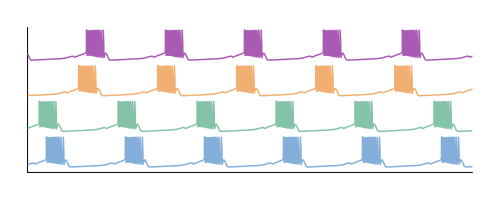

In [7]:
xl = (23.13, 25)
p1 = plot(tt/1e3, Vgallop2trot[tt_index, 2], xlims=xl, ylims=(-550,60), linewidth=1.5, 
          legend=false, color=myPurple, size=(500, 200), ticks=false)#, xticks=[20, 25], 
          #yticks=([-450, -300, -150, 0], ["LF", "RF", "RH", "LH"]))
plot!(tt/1e3, Vgallop2trot[tt_index, 4].-150, xlims=xl, ylims=(-550,60), linewidth=1.5, 
      legend=false, color=myOrange)
plot!(tt/1e3, Vgallop2trot[tt_index, 3].-300, xlims=xl, ylims=(-550,60), linewidth=1.5, 
      legend=false, color=myGreen)
plot!(tt/1e3, Vgallop2trot[tt_index, 1].-450, xlims=xl, ylims=(-550,60), linewidth=1.5, 
      legend=false, color=myBlue)
# savefig(p1, "galloponly.pdf")

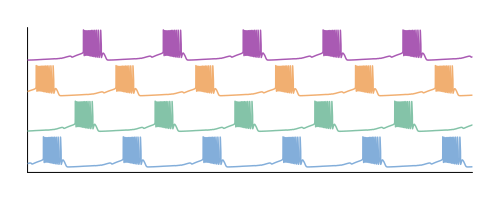

In [8]:
xl = (45.05, 46.9)
p1 = plot(tt/1e3, Vgallop2trot[tt_index, 2], xlims=xl, ylims=(-550,60), linewidth=1.5, 
          legend=false, color=myPurple, size=(500, 200), ticks=false)#, xticks=[20, 25], 
          #yticks=([-450, -300, -150, 0], ["LF", "RF", "RH", "LH"]))
plot!(tt/1e3, Vgallop2trot[tt_index, 4].-150, xlims=xl, ylims=(-550,60), linewidth=1.5, 
      legend=false, color=myOrange)
plot!(tt/1e3, Vgallop2trot[tt_index, 3].-300, xlims=xl, ylims=(-550,60), linewidth=1.5, 
      legend=false, color=myGreen)
plot!(tt/1e3, Vgallop2trot[tt_index, 1].-450, xlims=xl, ylims=(-550,60), linewidth=1.5, 
      legend=false, color=myBlue)
# savefig(p1, "trotonly.pdf")

In [23]:
xl = (35, 37)
p3 = plot(tt/1e3, Vgallop2trot[tt_index, 5], xlims=xl, ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=redGallop, ticks=false)
plot!(tt/1e3, Vgallop2trot[tt_index, 6], xlims=xl, ylims=(-100,60), linewidth=1.5, 
      legend=false, size=(600, 200), color=redGallop, alpha=0.8, axis=false)
p4 = plot(tt/1e3, Vgallop2trot[tt_index, 7], xlims=xl, ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=blueTrot, ticks=false, axis=false)
plot!(tt/1e3, Vgallop2trot[tt_index, 8], xlims=xl, ylims=(-100,60), linewidth=1.5, 
      legend=false, size=(600, 200), color=blueTrot, alpha=0.8)
# savefig(p4, "trotburst.pdf")

"C:\\Users\\arthu\\GitHub repositories\\PhD_WP3_network\\Quadrupet gait control\\trotburst.pdf"

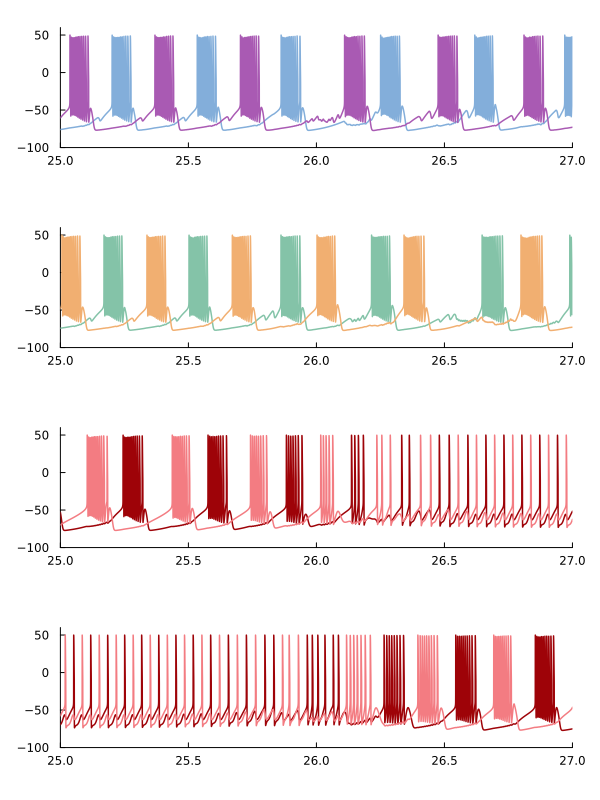

In [9]:
xl = (25, 27)
p1 = plot(tt/1e3, Vgallop2trot[tt_index, 1], xlims=xl, ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=myBlue)
plot!(tt/1e3, Vgallop2trot[tt_index, 2], xlims=xl, ylims=(-100,60), linewidth=1.5, 
      legend=false, size=(600, 200), color=myPurple)
p2 = plot(tt/1e3, Vgallop2trot[tt_index, 3], xlims=xl, ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=myGreen)
plot!(tt/1e3, Vgallop2trot[tt_index, 4], xlims=xl, ylims=(-100,60), linewidth=1.5, 
      legend=false, size=(600, 200), color=myOrange)
p3 = plot(tt/1e3, Vgallop2trot[tt_index, 5], xlims=xl, ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=myRed)
plot!(tt/1e3, Vgallop2trot[tt_index, 6], xlims=xl, ylims=(-100,60), linewidth=1.5, 
      legend=false, size=(600, 200), color=mySalmon)
p4 = plot(tt/1e3, Vgallop2trot[tt_index, 7], xlims=xl, ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=myRed)
plot!(tt/1e3, Vgallop2trot[tt_index, 8], xlims=xl, ylims=(-100,60), linewidth=1.5, 
      legend=false, size=(600, 200), color=mySalmon)
CC1 = plot(p1, p2, p3, p4, layout=(4, 1), size=(600, 800))

# Phase plots

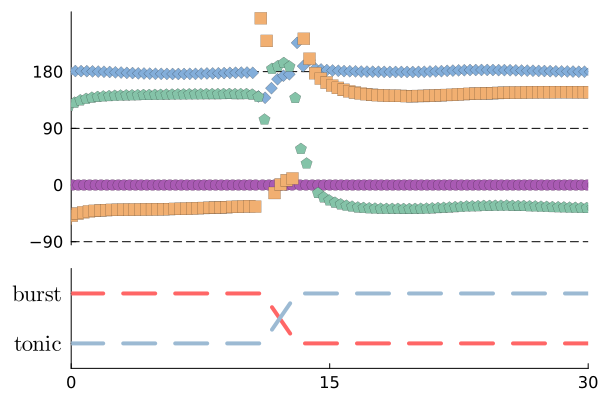

In [10]:
spike_times_firstLH = extract_firstspike_times(Vgallop2trot[tt_index, 2], tt)
spike_times_firstLF = extract_firstspike_times(Vgallop2trot[tt_index, 1], tt)
spike_times_firstRH = extract_firstspike_times(Vgallop2trot[tt_index, 4], tt)
spike_times_firstRF = extract_firstspike_times(Vgallop2trot[tt_index, 3], tt)

gr(guidefontsize=18, legendfontsize=12, margin=0Plots.mm, grid=false)

phase1, t1, phase2, t2, phase3, t3, phase4, t4 = computing_phases(spike_times_firstLH, 
    spike_times_firstLF, spike_times_firstRH, spike_times_firstRF);

p = hline([180], color=:black, linestyle=:dash, tickfontsize=11, xticks=false)
hline!([90], color=:black, linestyle=:dash)
hline!([-90], color=:black, linestyle=:dash)
scatter!(t1/1e3, phase1, label="LH", color=myPurple, legend=false, markerstrokewidth=0.2, 
    markersize=6)
scatter!(t2/1e3, phase2, label="LF", color=myBlue, markerstrokewidth=0.2, markershape=:diamond, 
    markersize=6)

scatter!(t3/1e3, phase3, label="RH", color=myOrange, markerstrokewidth=0.2, markershape=:rect, 
    markersize=6)
scatter!(t4/1e3, phase4, label="RF", color=myGreen, markerstrokewidth=0.2, markershape=:pentagon, 
    markersize=6)
xlims!((15, 45))
ylims!((-95, 275))
yticks!([-90, 0, 90, 180])
xaxis!(false)


myNmodRed = RGBA(255/255, 102/255, 102/255, 1)
myNmodBlue = RGBA(156/255, 186/255, 211/255, 1)
p2 = plot(ylims=(0, 2), tickfontsize=11)
ttt = [0, 11, 11.1, 13.1, 30]
thresh = 12
gallop(t) = 1.5*(t<=thresh) + 0.5 * (t>thresh)
trot(t) = 0.5*(t<=thresh) + 1.5 * (t>thresh)
plot!(ttt, gallop.(ttt), color=myNmodRed, linewidth=4, linestyle=:dash, legend=false)
plot!(ttt, trot.(ttt), color=myNmodBlue, linewidth=4, linestyle=:dash, ytickfontsize=15)
yticks!([0.5, 1.5], [L"\mathrm{tonic}", L"\mathrm{burst}"])
xticks!(([0, 15, 30], ["0", "15", "30"]))
xlims!((0, 30))

CC = plot(p, p2, layout = grid(2, 1, heights=[0.7, 0.3]), margin=1Plots.mm)
# savefig(CC, "phase_transition.pdf")

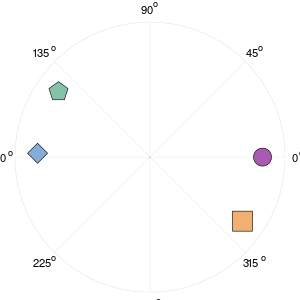

In [11]:
indexgallop = findall(t1 .> 24000 .&& t1 .< 25000)[1]
pp = scatter([phase1[indexgallop] * pi / 180], [1], proj = :polar, grid=true, ticks=false, 
             ylims=(0, 1.2), markersize=10, color=myPurple, legend=false, size=(300, 300))
scatter!([phase2[indexgallop] * pi / 180], [1], proj = :polar, grid=true, ticks=false, 
         markersize=10, color=myBlue, markershape=:diamond)
scatter!([phase3[indexgallop] * pi / 180], [1], proj = :polar, grid=true, ticks=false, 
         markersize=10, color=myOrange, markershape=:rect)
scatter!([phase4[indexgallop] * pi / 180], [1], proj = :polar, grid=true, ticks=false, 
         markersize=10, color=myGreen, markershape=:pentagon)
# savefig(pp, "polargallop.pdf")

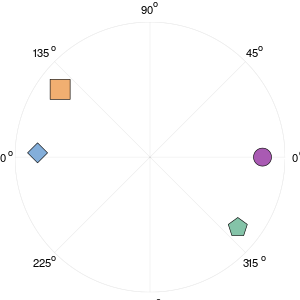

In [12]:
indexgallop = findall(t1 .> 49000 .&& t1 .< 50000)[1]
pp = scatter([phase1[indexgallop] * pi / 180], [1], proj = :polar, grid=true, ticks=false, 
             ylims=(0, 1.2), markersize=10, color=myPurple, legend=false, size=(300, 300))
scatter!([phase2[indexgallop] * pi / 180], [1], proj = :polar, grid=true, ticks=false, 
         markersize=10, color=myBlue, markershape=:diamond)
scatter!([phase3[indexgallop] * pi / 180], [1], proj = :polar, grid=true, ticks=false, 
         markersize=10, color=myOrange, markershape=:rect)
scatter!([phase4[indexgallop] * pi / 180], [1], proj = :polar, grid=true, ticks=false, 
         markersize=10, color=myGreen, markershape=:pentagon)
# savefig(pp, "polartrot.pdf")

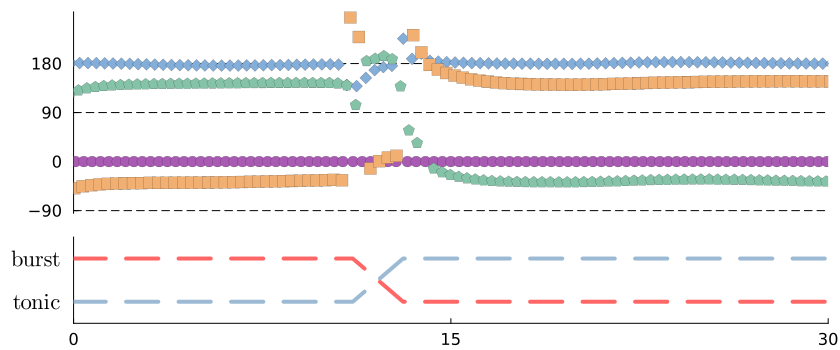

In [13]:
spike_times_firstLH = extract_firstspike_times(Vgallop2trot[tt_index, 2], tt)
spike_times_firstLF = extract_firstspike_times(Vgallop2trot[tt_index, 1], tt)
spike_times_firstRH = extract_firstspike_times(Vgallop2trot[tt_index, 4], tt)
spike_times_firstRF = extract_firstspike_times(Vgallop2trot[tt_index, 3], tt)

gr(guidefontsize=18, legendfontsize=12, margin=0Plots.mm, grid=false)

phase1, t1, phase2, t2, phase3, t3, phase4, t4 = computing_phases(spike_times_firstLH, 
    spike_times_firstLF, spike_times_firstRH, spike_times_firstRF);

p = hline([180], color=:black, linestyle=:dash, tickfontsize=11, xticks=false)
hline!([90], color=:black, linestyle=:dash)
hline!([-90], color=:black, linestyle=:dash)
scatter!(t1/1e3, phase1, label="LH", color=myPurple, legend=false, markerstrokewidth=0.2, 
    markersize=6)
scatter!(t2/1e3, phase2, label="LF", color=myBlue, markerstrokewidth=0.2, markershape=:diamond, 
    markersize=6)

scatter!(t3/1e3, phase3, label="RH", color=myOrange, markerstrokewidth=0.2, markershape=:rect, 
    markersize=6)
scatter!(t4/1e3, phase4, label="RF", color=myGreen, markerstrokewidth=0.2, markershape=:pentagon, 
    markersize=6)
xlims!((15, 45))
ylims!((-95, 275))
yticks!([-90, 0, 90, 180])
xaxis!(false)


myNmodRed = RGBA(255/255, 102/255, 102/255, 1)
myNmodBlue = RGBA(156/255, 186/255, 211/255, 1)
p2 = plot(ylims=(0, 2), tickfontsize=11)
ttt = [0, 11, 11.1, 13.1, 30]
thresh = 12
gallop(t) = 1.5*(t<=thresh) + 0.5 * (t>thresh)
trot(t) = 0.5*(t<=thresh) + 1.5 * (t>thresh)
plot!(ttt, gallop.(ttt), color=myNmodRed, linewidth=4, linestyle=:dash, legend=false)
plot!(ttt, trot.(ttt), color=myNmodBlue, linewidth=4, linestyle=:dash, ytickfontsize=15)
yticks!([0.5, 1.5], [L"\mathrm{tonic}", L"\mathrm{burst}"])
xticks!(([0, 15, 30], ["0", "15", "30"]))
xlims!((0, 30))

CC = plot(p, p2, layout = grid(2, 1, heights=[0.7, 0.3]), margin=1Plots.mm, size=(840,350))
# savefig(CC, "phase_transition.pdf")

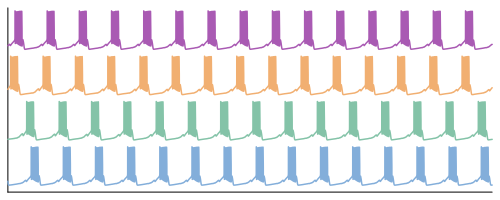

In [18]:
xl = (15, 20)
p1 = plot(tt/1e3, Vgallop2trot[tt_index, 2], xlims=xl, ylims=(-550,60), linewidth=1.5, 
          legend=false, color=myPurple, size=(500, 200), ticks=false)#, xticks=[20, 25], 
          #yticks=([-450, -300, -150, 0], ["LF", "RF", "RH", "LH"]))
plot!(tt/1e3, Vgallop2trot[tt_index, 4].-150, xlims=xl, ylims=(-550,60), linewidth=1.5, 
      legend=false, color=myOrange)
plot!(tt/1e3, Vgallop2trot[tt_index, 3].-300, xlims=xl, ylims=(-550,60), linewidth=1.5, 
      legend=false, color=myGreen)
plot!(tt/1e3, Vgallop2trot[tt_index, 1].-450, xlims=xl, ylims=(-550,60), linewidth=1.5, 
      legend=false, color=myBlue)
# savefig(p1, "galloponly_nocrash.pdf")

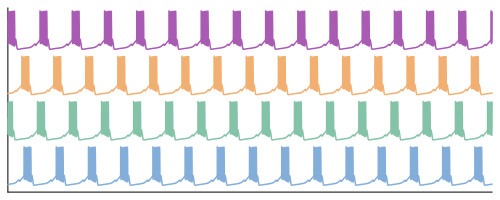

In [20]:
xl = (30, 35)
p1 = plot(tt/1e3, Vgallop2trot[tt_index, 2], xlims=xl, ylims=(-550,60), linewidth=1.5, 
          legend=false, color=myPurple, size=(500, 200), ticks=false)#, xticks=[20, 25], 
          #yticks=([-450, -300, -150, 0], ["LF", "RF", "RH", "LH"]))
plot!(tt/1e3, Vgallop2trot[tt_index, 4].-150, xlims=xl, ylims=(-550,60), linewidth=1.5, 
      legend=false, color=myOrange)
plot!(tt/1e3, Vgallop2trot[tt_index, 3].-300, xlims=xl, ylims=(-550,60), linewidth=1.5, 
      legend=false, color=myGreen)
plot!(tt/1e3, Vgallop2trot[tt_index, 1].-450, xlims=xl, ylims=(-550,60), linewidth=1.5, 
      legend=false, color=myBlue)
# savefig(p1, "trotonly_nocrash.pdf")